In [1]:
import torch
from d2l import torch as d2l
import torchvision
import numpy as np
from torchvision import transforms
from matplotlib import pyplot as plt
# plt.rcParams.update({'figure.max_open_warning': 0})

# Idea

This is a simple classification model that aims to classify the classic MNIST hand-drawn number dataset. Given a 28x28 black and white image, we categorize the input into one of 10 digits.

The model uses two core principals:
- Softmax Regression
- Minibatch Stocastic Gradient Descent (MSGD)

We can think of the classification problem as trying to perform regression for each of the 10 possible outputs. We can solve each of these regression problems using (Minibatch Stocastic) Gradient Descent. Our model will then generate the probabilties that any given input corresponds to one of 10 outputs.

Because we are dealing with probabilities, using MSGD straight away leads to two problems
- The sum of the output probabilties is not guaranteed to be = 1
- Probabiltities are not guaranteed to be > 1

We use Softmax to fix these problems. 
Softmax takes an input X and transforms it into a form with positive values and normalized rows.

In [2]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here to fill the tensors

Implementation for the softmax classification algorithm

In [3]:
class MySoftmaxRegression(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

    def forward(self, X):
        return softmax(torch.matmul(X.reshape((-1, self.W.shape[0])), self.W) + self.b)

# the loss function uses cross entropy loss
    def loss(self, y_hat, y):
        return - torch.log(y_hat[list(range(len(y_hat))), y]).mean()

Data to classify

In [4]:
class MNIST(d2l.DataModule):  #@save
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        #defines how to reshape the inputs
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()]) 
        self.trainingData = torchvision.datasets.MNIST(root=self.root, train=True, 
                                                       transform=trans, download=True)
        self.testingData = torchvision.datasets.MNIST(root=self.root, train=False, 
                                                      transform=trans, download=True)

    def text_labels(self, indices):
        labels = ['0','1','2','3','4','5','6','7','8','9']
        return [labels[int(i)] for i in indices]

    # for each iteration, we read a minibatch of randomly shuffled data 
    def get_dataloader(self, train):
        data = self.trainingData if train else self.testingData
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train, num_workers=self.num_workers)
    
    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
        
#     batch = next(iter(data.get_dataloader(False)))
#     data.visualize(batch)

# TRAINING
This uses mini-batch stocastic gradient descent with batch_size = 256
we treat each 28x28 image as a vector with 784 entries. 

In [5]:
data = MNIST(batch_size=256)
model = MySoftmaxRegression(num_inputs=784, num_outputs=10, lr=0.1)

The built in fit function grabs a minibatch and passes over the entire dataset to computer the loss.
Next the gradient is found w/rt each parameter, and the optimization algorithm updates parameters

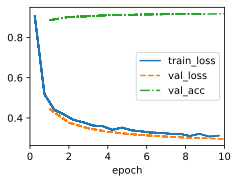

In [6]:
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# Find the accuracy of the model after 10 epochs:

In [8]:
accuracy = MySoftmaxRegression.accuracy(model, model(X), y)
print("accuracy: ", accuracy.item())

accuracy:  0.9453125


# TESTING
Use trained model to predict classification for new images. 
Grab a batch of data.

In [7]:
X, y = next(iter(data.get_dataloader(False)))
preds = model(X).argmax(axis=1)




# Show some correctly labeled images

In [9]:
correct = preds.type(y.dtype) == y
Xc, yc, predsc = X[correct], y[correct], preds[correct]
labels = ["guessed: "+ b +'\n'+ "answer: " + a for a, b in zip(data.text_labels(yc), data.text_labels(predsc))]

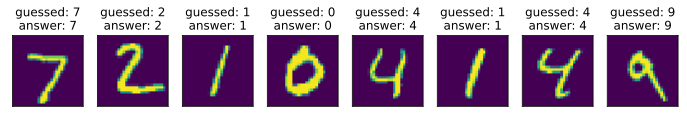

In [10]:
plt.close('all')
data.visualize([Xc, yc], labels=labels)

# Show the incorrectly labeled images.

In [11]:
wrong = preds.type(y.dtype) != y
Xi, yi, predsi = X[wrong], y[wrong], preds[wrong]
labels = ["guessed: "+ b +'\n'+ "correct: " + a for a, b in zip(data.text_labels(yi), data.text_labels(predsi))]

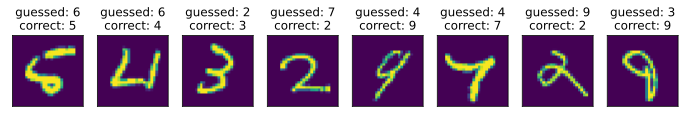

In [12]:
plt.close('all')
data.visualize([Xi, yi], labels=labels)

Most code from the notebook is taken from the D2L textbook:

Dive into Deep Learning, Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J., arXiv preprint arXiv:2106.11342, 2021